In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
L_x = 100
g = 9.81
H = 100

N_x = 301
dx = L_x/(N_x - 1)
dt = 0.002
N_t = 50000
err = 1e-4
x = np.linspace(0,L_x,N_x)
h = np.zeros(N_x)
u = np.zeros(N_x)
D = 100
slope = lambda x: 0.7*(x>700)*(x-700)
# slope = lambda x: 0.2*x

b = slope(x)
H = D - b
b_ = np.zeros(N_x)
# b = np.zeros(N_x)
# h = 10*np.exp(-((x)**2/(2*(0.05E+3)**2)))
h[int(1*N_x/16):int(2*N_x/8)] = 50
nu = 0.01

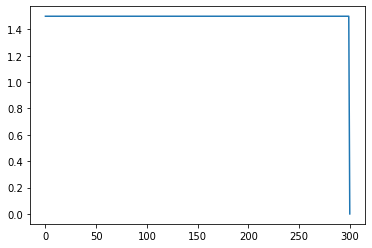

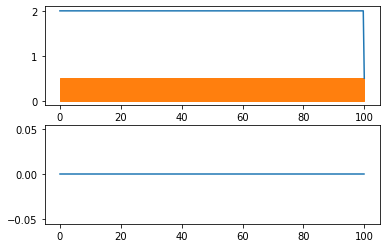

In [4]:
h = np.ones(N_x)*0.5

h[:300]= 2
slope = lambda x,b,L: (x>=b)*(x-b)*(L/(L_x-b))
dam  = lambda x,a,b,L: ((x>=a)&(x<=b))*L

u = np.zeros(N_x)
z = np.ones(N_x)*0.5
s = slope(x,90,2)
d = dam(x,20,30,3)
z = z
z_ = np.zeros(N_x)

h = np.where(h>=z,h-z,0)
plt.plot(h)
plt.show()
# z[150:200]=0
fig, (axh,axu) = plt.subplots(2, 1,facecolor ='white')
line_u,=axu.plot(x,u)
line_h,=axh.plot(x,h+z)
fill_=axh.fill_between(x,z,z_,color ='tab:orange')

In [72]:
N_x = 99 # for Fx,and Px
N_y = 49  # for Fy,and Py

U_x = N_x + 2 
U_y = N_y

V_x = N_x
V_y = N_y + 2

L_x = 100
L_y = 100

U = np.zeros((U_x,U_y+2)) # N_x+2, N_y    , N_x [0,last] =0,and if you N_y +2 for convinient, so -1, max+ 1 also 0 for BC
V = np.zeros((V_x+2,V_y)) # N_x  , N_y + 2, N_y [0,last] =0,and if you N_x +2 for convinient, so -1, max+ 1 also 0 for BC


x = np.linspace(0,L_x,U_x,endpoint=True) # contain the boundary, make the all area
y = np.linspace(0,L_y,V_y,endpoint=True) # contain the boundary, make the all area
X,Y = np.meshgrid(x,y,indexing='ij')



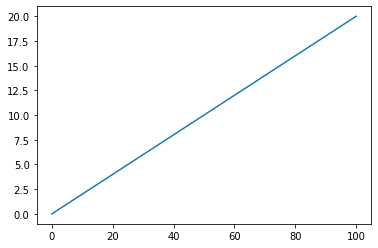

In [79]:
slope = lambda x,b,L: (x>=b)*(x-b)*(L/(L_x-b))
B_X = slope(X,0,20)
plt.plot(x,slope(x,0,20))
BC = np.where(((X==0)|(X == L_x)|(Y==0)|(Y==L_y)|(Y<B_X)))

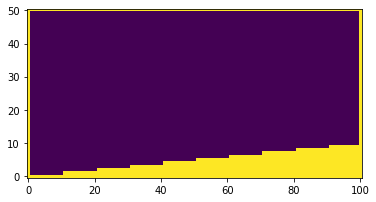

In [80]:
# BC = np.where(Y<B_X)
U[BC] = 1
plt.imshow(U.T,origin='lower')
